<a href="https://colab.research.google.com/github/AbigailBojorquez/Sales-Predictions/blob/main/Sales_Presentation_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import plot_tree
from sklearn import set_config
from sklearn.impute import SimpleImputer
set_config(display='diagram')

In [76]:
# Create a function to take the true and predicted labels and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

In [77]:
path = '/content/drive/MyDrive/Coding Dojo/Fundamentals /Week 1/sales_predictions.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [78]:
#making copy of df
ml_df = df.copy()

In [79]:
ml_df.drop(columns= ['Item_Identifier', 'Outlet_Establishment_Year', 'Outlet_Identifier'],inplace = True)

In [80]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           7060 non-null   float64
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  8523 non-null   object 
 7   Outlet_Type           8523 non-null   object 
 8   Item_Outlet_Sales     8523 non-null   float64
dtypes: float64(4), object(5)
memory usage: 599.4+ KB


In [81]:
ml_df.isna().sum()

Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

In [82]:
ml_df.dropna(inplace= True)

In [83]:
ml_df['Item_Fat_Content'].value_counts()

Low Fat    2774
Regular    1575
LF          177
reg          71
low fat      53
Name: Item_Fat_Content, dtype: int64

In [84]:
fat_content_map = {'LF':'Low Fat',
                   'reg':'Regular',
                   'low fat':'Low Fat'}

ml_df['Item_Fat_Content'] = ml_df['Item_Fat_Content'].replace(fat_content_map)

## Verify 
ml_df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

In [85]:
# Split
X = ml_df.drop(['Item_Outlet_Sales', 'Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], axis=1)
y = ml_df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [86]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [87]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [88]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [89]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [90]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder= 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7326131a50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f73261533d0>)])

In [91]:
## Make and fit model
tree_pipe = make_pipeline(preprocessor,DecisionTreeRegressor())
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7326131a50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73261533d0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [92]:
evaluate_regression(y_train, tree_pipe.predict(X_train))

scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.00 
R2: 1.00


In [93]:
evaluate_regression(y_test, tree_pipe.predict(X_test))

scores: 
MAE: 1,175.52 
MSE: 2,590,597.43 
RMSE: 1,609.53 
R2: -0.17


In [94]:
tree_pipe[-1].get_depth()

30

# Decision Tree

In [95]:
dec_Tree = DecisionTreeRegressor(max_depth=None)
dec_reg_pipe = make_pipeline(preprocessor, dec_Tree)
dec_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7326131a50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73261533d0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [96]:
dec_tree_2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
dec_tree_2.fit(X_train, y_train)
train_2_score = dec_tree_2.score(X_train, y_train)
test_2_score = dec_tree_2.score(X_test, y_test)
print(train_2_score)
print(test_2_score)

0.432229322497355
0.4366592009129475


In [97]:
depths = list(range(2, 42)) # will try every value between 2 and 36
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


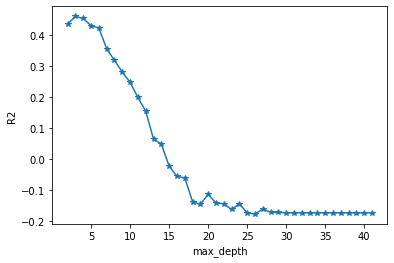

In [98]:
# Visualize which max_depth leads to the highest r2 score
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'], marker = '*')
plt.xlabel('max_depth')
plt.ylabel('R2');

In [99]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
3,0.461687,0.457636
4,0.454748,0.467571
2,0.436659,0.432229
5,0.431643,0.47974
6,0.423851,0.49853


# Bagged Trees

In [110]:
bagreg_tree_2 = BaggingRegressor(random_state = 42)
bagreg_tree_2.fit(X_train, y_train)
train_2_score = bagreg_tree_2.score(X_train, y_train)
test_2_score = bagreg_tree_2.score(X_test, y_test)
print(train_2_score)
print(test_2_score)

0.8743808724944424
0.269622612832331


In [111]:
# List of estimator values
estimators = [10, 20, 30, 40, 50, 100]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train, y_train)
   train_score = bag_reg.score(X_train, y_train)
   test_score = bag_reg.score(X_test, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score

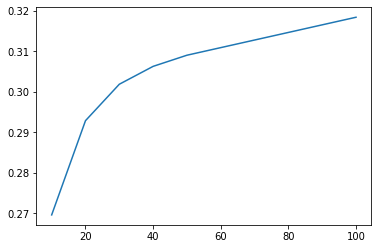

In [112]:
plt.plot(scores['Test Score'])
plt.show()

In [113]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
100,0.90557,0.318427
50,0.901148,0.309051
40,0.899771,0.306299
30,0.898133,0.301885
20,0.893348,0.292889
10,0.874381,0.269623


In [114]:
# Save the index value of the best test score.
best_n_estimators = scores.index[0]
# Instantiate and fit the best version of the model
bag_reg_tuned = BaggingRegressor(n_estimators=best_n_estimators,)
bag_reg_tuned.fit(X_train, y_train)
# Evaluate the model
print(bag_reg_tuned.score(X_train, y_train))
print(bag_reg_tuned.score(X_test, y_test))

0.9057135928333921
0.31909092007849416


# Evaluations

In [115]:
best_model = DecisionTreeRegressor(max_depth=3,random_state=42)
best_model.fit(X_train,y_train)
evaluate_regression(y_train, best_model.predict(X_train))

scores: 
MAE: 816.30 
MSE: 1,220,723.00 
RMSE: 1,104.86 
R2: 0.46


In [117]:
best_model = BaggingRegressor(n_estimators= 100,random_state=42)
best_model.fit(X_train,y_train)
evaluate_regression(y_train, best_model.predict(X_train))

scores: 
MAE: 337.54 
MSE: 212,537.67 
RMSE: 461.02 
R2: 0.91


# Our decision Tree can account for about 46% of the variation in y_test using the features in X_test. Although, our numbers look a little high on the MAE and RMSE, our R2 is still between 0 and 1, this indicates that our data is well balenced. 